In [1]:
import os.path
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import itertools
import seaborn as sns

from scipy import interpolate
from matplotlib import pyplot as plt

torch.Size([1000, 2])


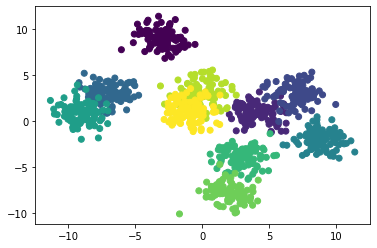

In [4]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data']
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

print(data.shape)

100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


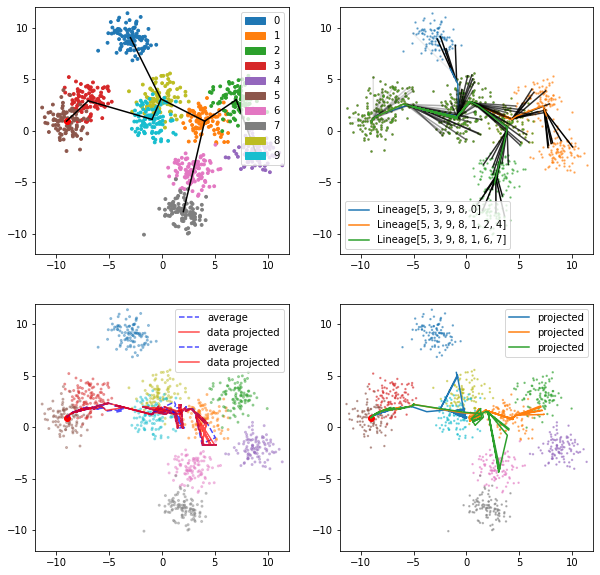

In [54]:
from slingshot import Slingshot

slingshot = Slingshot(data, cluster_labels_onehot, start_node=start_node, debug_axes=None)

In [ ]:
tttttt


In [ ]:
def scipy_interpolate():
    x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
    y = np.sin(x)

    tck = interpolate.splrep(x, y, s=0.5)
    xnew = np.arange(0, 2*np.pi, np.pi/50)

    ynew = interpolate.splev(xnew, tck, der=0)

    plt.plot(xnew, ynew)
    plt.plot(xnew, np.sin(xnew))


